## Mfundo Monchwe
### Student no: 1645850
### ACML Project


### Problem Statement
Given lot of patients have heart disease, and sometimes it hard to predict whether someone has heart disease or not, simply because all models are not perfect and others models are not confident enough and unable to quantify the uncertainty

### Research Questions

1.which model is appropriate to predict whether patient is sick or not

2.how are we gonna split the dataset?

3.Which one of the functional requirements to perform diagonsis?

4.how can the clients trust this model?

5.How do we choose our priors?

 6.which Probability Distribution will selected for modelling?
 
 ### Objectives
 1. Probabilistic Logistic regression Model
 Using Bayesian Formula:
     $$ P(\theta|D)= \frac{P(\theta)P(D|\theta)}{P(D)}$$
     Where $P(\theta|D)$ ~ Posterior for $\theta$ given $D$  and $P(D|\theta)$ Likelihood for $\theta$
     $P(\theta)$~ for $\theta$ and $P(D)$
     Evidence of the model which can simplify it as:
     $$ P(Model|Data) = \frac{P(Model)P(Data|Model)}{P(Data)}$$
     
     Model selection will be informed by the principle of Occam's Razor by selecting variable $y_{i}$
     $$P(Model_{i}|Data) = \frac{P(Model_{i})P(Data|Model_{i})}{P(Data)}$$
     The final Selected model will be used to predict whether the patient is sick or not
     $P(y_{i}|data,\theta) = \int P(y_{i}|data,\theta)d\theta$
     
  2. splitting the dataset into 80% training and 20%


In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import pymc3 as pm
import theano as T
import arviz as az
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import pickle
from pymc3.variational.callbacks import CheckParametersConvergence

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## Data Set Description 
The data used for this problem is a [Multivariate Heart Disease Data Set from UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Heart+Disease/). The data set database contains 76 attributes, but all published experiments refer to using a subset of 14 of them. In particular, the Cleveland database is the only one that has been used by ML researchers to this date. `The "target" field refers to the presence of heart disease in the patient`. 

**Attribute Information** 


| Attribute | Description | Type |
| --- | --- | --- |
| `age` | Patient's age in years | numerical |
| `sex` | sex (1 = male; 0 = female) | nominal/binomial |
| `cp` | chest pain type (1 = typical angina, 2 = atypical angina, 3 = non-anginal pain, 4 = asymptomatic) | nominal |
| `trestps` | resting blood pressure (in mm Hg on admission to the hospital) | numerical |
| `chol` | serum cholestoral in mg/dl | numerical |
| `fbs` | (fasting blood sugar > 120 mg/dl) (1 = true; 0 = false) | binomial/nominal |
| `restecg` | resting electrocardiographic results (normal; abnormal; ventricular hypertrophy) | nominal |
| `thalach` | maximum heart rate achieved | numerical |
| `exang` | exercise induced angina (1 = yes; 0 = no) | binomial/nominal |
| `oldpeak` | ST depression induced by exercise relative to rest | numerical |
| `slope` | the slope of the peak exercise ST segment (1 = upsloping; 2 = flat; 3 = downsloping) | nominal |
| `ca`  | number of major vessels colored by  fluoroscopy (0 = mild; 1 = moderate; 3 = severe) | nominal |
| `thal`  | Status of the heart (1 = normal; 2 = fixed defect; 3 = reversible defect) | nominal |
| `target` | (1 = heart disease; 0 = healthy) | binomial/nominal |

## Why Probabilistic Machine Learning for Heart Disease Diagnosis?

Medical uncertainty is considered as a natural feature for medicine and medical practice. Understanding medical uncertainty and acquiring proper coping strategies is regarded as a core clinical competency for medical specialists. Medical practice is properly known to be full of uncertainty. Even medical specialists face uncertainty, especially regarding complex co-morbid medical conditions that may hinder applications of existing medical evidences. `(Kim & Lee, 2018)`

Diagnostic uncertainty is a subjective perception of inability to provide an accurate explanation of the patient's health problem `(Bhise, Rajan, Sittig, Morgan, Chaudhary & Signh, 2017)`. Dealing with uncertainty in diagnostic focuses on shared decision making, establishing a relationship of trust with patients and meticulous evaluation. The problem of employing machine learning to help practitioners solve the problem of heart disease, has a decision making element. This is deciding if a patient is sick (heart disease) or healthy.  Uncertainty is a key ingredient in this problem, where decision making depends on the amount of uncertainty. 

Probabilistic machine learning will provide opportunities for modeling uncertainty, performing probabilistic inference, combining prior knowledge and empirical evidence and making predictions or decisions in uncertain environments (heart disease diagnose). In this problem uncertainty can be incorporated by using probabilities to express the degree of uncertainty. This will enable machine learning models or systems to advise when uncertain or when it does not know, this can be reassuring for patients, as they would be concerned with trusting artificial intelligent systems. The solution to this problem will adopt a probabilistic framework which will aid in representing and manipulating uncertainty about the models and predictions.

More about uncertainty in medical diagnosis: [PubMed: National Library of Medicine](https://pubmed.ncbi.nlm.nih.gov/28936618/) and [National Center for Biotechnology Information](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6127608/)

**A generative model will be developed for this problem such that:** <br>
- `P( θ | data ) ∝ P( data | θ )P(θ)` *whereby:* <br>
- `P( data | θ )` will be the likelihood of the response feature given the model and predictor features. `P( data | θ )` is the conditional distribution of the response and predictor features given the model. It is data-driven and as the number of sample data increases the likelihood overwhelms the prior distribution <br>
- `P(θ)` will be the prior probability of the model parameters. `P(θ)` is the guess of the model parameters over the predictor features based on domain knowledge <br>
- `P( θ | data )` will be the posterior of model parameters. `P( θ | data )` is the conditional distribution of the model parameters given the response and predictor features. The posterior `P( θ | data )` will be sampled using Markov Chain Monte Carlo (MCMC) <br>
The probabilistic machine learning model will be formulated considering probability distributions and prior before seeing the data instead of just the training data. <br> <br>
`Predictor Features:` age, sex, cp, trestbps, chol, fbs, restecg, thalach, exang, oldpeak, slope, ca, thal <br>
`Response Feature:` target (heart disease)

In [2]:
data = pd.read_csv("C:/Users/Mfund/Downloads/ACML_Project/heart.csv")

In [3]:
data.sample(5)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
637,58,0,2,120,340,0,1,172,0,0.0,2,0,2,1
427,57,1,2,150,168,0,1,174,0,1.6,2,0,2,1
60,29,1,1,130,204,0,0,202,0,0.0,2,0,2,1
228,52,1,1,128,205,1,1,184,0,0.0,2,0,2,1
478,39,1,2,140,321,0,0,182,0,0.0,2,0,2,1


## Questions to understand the heart disease data set
`Predictor Features:` age, sex, cp, trestbps, chol, fbs, restecg, thalach, exang, oldpeak, slope, ca, thal <br>
`Response Feature:` target (heart disease) <br>
`Numerical Features:` Numerical features represent values that can be measured and put into a logical order. In the heart disease patient data set, the numerical features are *age, trestbps, chol, thalach and oldpeak* <br>
`Categorical Features:` Categorical features can only take on a limited, and usually fixed, number of possible values. In the heart disease patient data set, the categorical features are *sex, cp, fbs, restecg, exang, slope, ca, thal and target* <br>
`Class:` In this context classes are the fixed possible values in the categorical features, e.g., *sex* having 2 classes which is male (represented as 1) and female (represented as 0). 

**Questions**
- How does the classes in the categorical features vary in numbers?
- How are the numerical features distributed?
- How does the classes in the categorical features vary in numbers according to the target feature?
- How are the numerical features distributed according to the target feature?
- Are the predictor features related to the response feature?
- Are the predictor features and target feature linearly or non-linearly related?
- Does the variation in the target feature change depending on the predictor features?
- Are there any outliers?
- Which features are most predictive for heart disease diagnosis? 
- Are all the classes well represented in the target feature? (Does class imbalance exist?)

## Heart Disease data examination

### Dataset information

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1025 entries, 0 to 1024
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1025 non-null   int64  
 1   sex       1025 non-null   int64  
 2   cp        1025 non-null   int64  
 3   trestbps  1025 non-null   int64  
 4   chol      1025 non-null   int64  
 5   fbs       1025 non-null   int64  
 6   restecg   1025 non-null   int64  
 7   thalach   1025 non-null   int64  
 8   exang     1025 non-null   int64  
 9   oldpeak   1025 non-null   float64
 10  slope     1025 non-null   int64  
 11  ca        1025 non-null   int64  
 12  thal      1025 non-null   int64  
 13  target    1025 non-null   int64  
dtypes: float64(1), int64(13)
memory usage: 112.2 KB


In [5]:
#check for duplicates
duplicate_data = data[data.duplicated()]
duplicate_data

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
15,34,0,1,118,210,0,1,192,0,0.7,2,0,2,1
31,50,0,1,120,244,0,1,162,0,1.1,2,0,2,1
43,46,1,0,120,249,0,0,144,0,0.8,2,0,3,0
55,55,1,0,140,217,0,1,111,1,5.6,0,0,3,0
61,66,0,2,146,278,0,0,152,0,0.0,1,1,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1020,59,1,1,140,221,0,1,164,1,0.0,2,0,2,1
1021,60,1,0,125,258,0,0,141,1,2.8,1,1,3,0
1022,47,1,0,110,275,0,0,118,1,1.0,1,1,2,0
1023,50,0,0,110,254,0,0,159,0,0.0,2,0,2,1


In [6]:
#count the number of duplicate values
data.duplicated().sum()

723

In [7]:
#length of dataset prior removing duplicates
len(data)

1025

In [8]:
#removing duplicate data
data.drop_duplicates(keep='first', inplace=True)

In [9]:
len(data)

302

In [10]:
# check for duplicates if there's any
duplicate_data = data[data.duplicated()]
duplicate_data

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target


In [11]:
#count the number of duplicate values
data.duplicated().sum()

0

### Percentage of missing values

In [12]:
(data.isnull().sum() * 100 / data.shape[0]).sort_values(ascending=False)

age         0.0
sex         0.0
cp          0.0
trestbps    0.0
chol        0.0
fbs         0.0
restecg     0.0
thalach     0.0
exang       0.0
oldpeak     0.0
slope       0.0
ca          0.0
thal        0.0
target      0.0
dtype: float64

No missing values are detected in the dataset

## Data Visualisation to understand the heart disease dataset

### How does the classes in  the categorixal features vary in numbers?

* The charts below (bar plots) provides a count comparison between the classes present in the categorical features. The count is the number of patients present in the classes being compared. These plots will provide sense of the number of patients present in each class being compared or the number of patients that have the compared class condition.

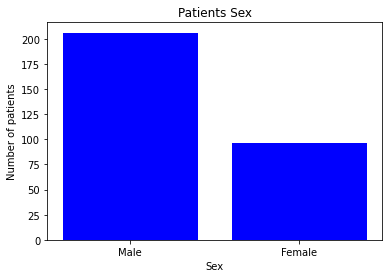

In [13]:
sex_cat = data['sex'].value_counts().rename_axis("Sex").reset_index(name='Count')
sex_cat = sex_cat.replace({'Sex': {0 : 'Female', 1: 'Male'}})
plt.bar(sex_cat.Sex, sex_cat.Count, color = 'blue');
plt.title('Patients Sex');
plt.xlabel('Sex');
plt.ylabel('Number of patients');

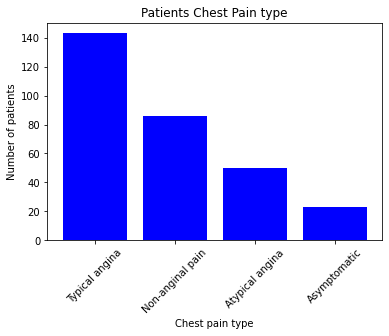

In [14]:
cp_cat = data['cp'].value_counts().rename_axis("Cp").reset_index(name='Count')
cp_cat = cp_cat.replace({'Cp': {0 : 'Typical angina', 1: 'Atypical angina',
                                2: 'Non-anginal pain', 3: 'Asymptomatic'}})
plt.bar(cp_cat.Cp, cp_cat.Count, color = 'blue');
plt.title('Patients Chest Pain type');
plt.xlabel('Chest pain type');
plt.ylabel('Number of patients');
plt.xticks(rotation=45);

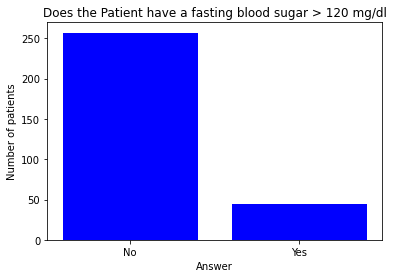

In [15]:
fbs_cat = data['fbs'].value_counts().rename_axis("Fbs").reset_index(name='Count')
fbs_cat = fbs_cat.replace({'Fbs': {0 : 'No', 1: 'Yes'}})
plt.bar(fbs_cat.Fbs, fbs_cat.Count, color = 'blue');
plt.title('Does the Patient have a fasting blood sugar > 120 mg/dl');
plt.xlabel('Answer');
plt.ylabel('Number of patients');

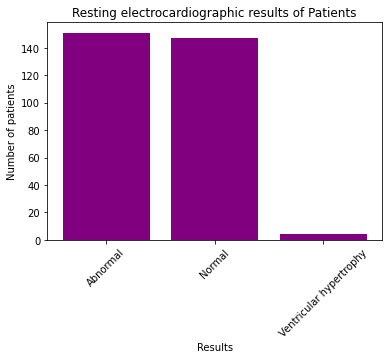

In [16]:
restecg_cat = data['restecg'].value_counts().rename_axis("Restecg").reset_index(name='Count')
restecg_cat = restecg_cat.replace({'Restecg': {0 : 'Normal', 1: 'Abnormal', 2: 'Ventricular hypertrophy'}})
plt.bar(restecg_cat.Restecg, restecg_cat.Count, color = 'purple');
plt.title('Resting electrocardiographic results of Patients');
plt.xlabel('Results');
plt.ylabel('Number of patients');
plt.xticks(rotation=45);

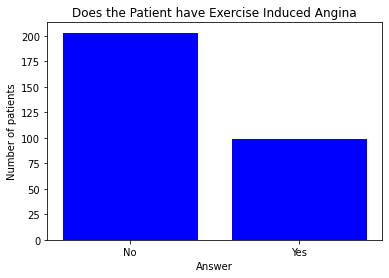

In [17]:
exang_cat = data['exang'].value_counts().rename_axis("Exang").reset_index(name='Count')
exang_cat = exang_cat.replace({'Exang': {0 : 'No', 1: 'Yes'}})
plt.bar(exang_cat.Exang, exang_cat.Count, color = 'blue');
plt.title('Does the Patient have Exercise Induced Angina');
plt.xlabel('Answer');
plt.ylabel('Number of patients');

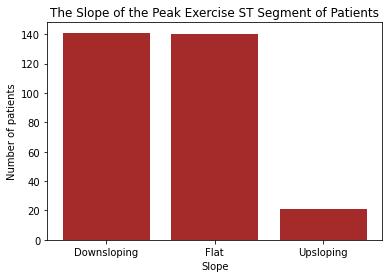

In [18]:
slope_cat = data['slope'].value_counts().rename_axis("Slope").reset_index(name='Count')
slope_cat = slope_cat.replace({'Slope': {0 : 'Upsloping', 1: 'Flat', 2: 'Downsloping'}})
plt.bar(slope_cat.Slope, slope_cat.Count, color = 'brown');
plt.title('The Slope of the Peak Exercise ST Segment of Patients');
plt.xlabel('Slope');
plt.ylabel('Number of patients');

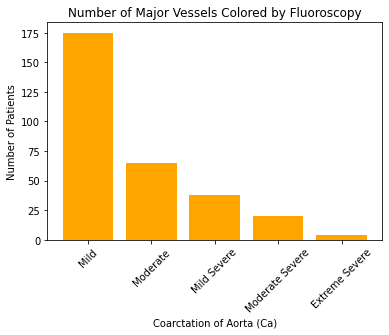

In [19]:
ca_cat = data['ca'].value_counts().rename_axis("Ca").reset_index(name='Count')
ca_cat = ca_cat.replace({'Ca': {0 : 'Mild', 1: 'Moderate', 2: 'Mild Severe',
                               3: 'Moderate Severe', 4: 'Extreme Severe'}})
plt.bar(ca_cat.Ca, ca_cat.Count, color = 'Orange');
plt.title('Number of Major Vessels Colored by Fluoroscopy');
plt.xlabel('Coarctation of Aorta (Ca)');
plt.ylabel('Number of Patients');
plt.xticks(rotation=45);

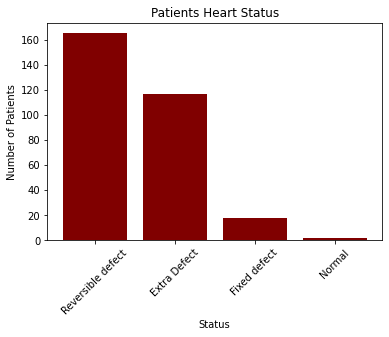

In [20]:
thal_cat = data['thal'].value_counts().rename_axis("Thal").reset_index(name='Count')
thal_cat = thal_cat.replace({'Thal': {0 : 'Normal', 1: 'Fixed defect', 2: 'Reversible defect',
                               3: 'Extra Defect'}})
plt.bar(thal_cat.Thal, thal_cat.Count, color = 'maroon');
plt.title('Patients Heart Status');
plt.xlabel('Status');
plt.ylabel('Number of Patients');
plt.xticks(rotation=45);

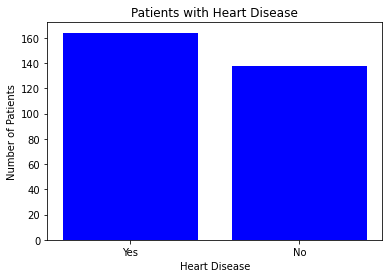

In [21]:
target_cat = data['target'].value_counts().rename_axis("Target").reset_index(name='Count')
target_cat = target_cat.replace({'Target': {0 : 'No', 1: 'Yes'}})
plt.bar(target_cat.Target, target_cat.Count, color = 'blue');
plt.title('Patients with Heart Disease');
plt.xlabel('Heart Disease');
plt.ylabel('Number of Patients');

## How are the numerical features distributed

- The charts below (histogram + KDE + rug plot) provide a distribution of numerical features. The distribution plots provide an illustration of how the data is distributed in terms of shape/curve and which data points (numerical values) are most frequent. The frequent data points can be pinpointed by observing the curve peaks or peaks of the distribution plots. The black lined added to the distribution plots is to match a normal distribution to observe if the numerical feature being observed follows a normal distribution. The data points of the numerical feature are shown in the horizontal axis (x-axis) and the probability of the data points occurring is shown in the vertical axis (y-axis). Lastly, the mini-lines displayed at the bottom of the distribution plots are indications of the data points occurring frequently, in the range in which they are displayed. 

C:\Users\Mfund\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Mfund\anaconda3\lib\site-packages\seaborn\distributions.py:2056: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


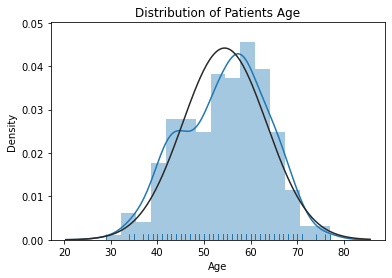

In [22]:
from scipy.stats import norm, skewnorm, halfcauchy

# Fit a normal distribution to the data to observe if it is normally distributed 
sns.distplot(data.age, rug=True, bins=15, fit=norm);
plt.title('Distribution of Patients Age');
plt.xlabel('Age');

C:\Users\Mfund\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Mfund\anaconda3\lib\site-packages\seaborn\distributions.py:2056: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


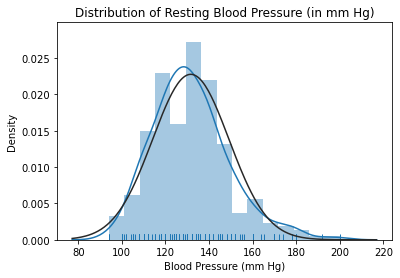

In [23]:
sns.distplot(data.trestbps, rug=True, bins=15, fit=norm);
plt.title('Distribution of Resting Blood Pressure (in mm Hg)');
plt.xlabel('Blood Pressure (mm Hg)');

C:\Users\Mfund\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Mfund\anaconda3\lib\site-packages\seaborn\distributions.py:2056: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


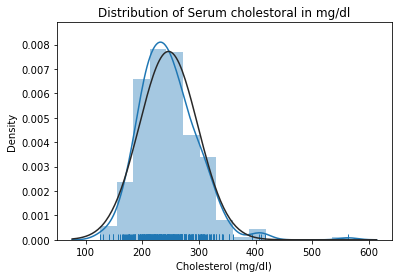

In [24]:
sns.distplot(data.chol, rug=True, bins=15, fit=norm);
plt.title('Distribution of Serum cholestoral in mg/dl');
plt.xlabel('Cholesterol (mg/dl)');

C:\Users\Mfund\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Mfund\anaconda3\lib\site-packages\seaborn\distributions.py:2056: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


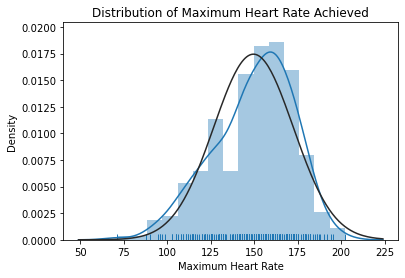

In [25]:
sns.distplot(data.thalach, rug=True, bins=15, fit=norm);
plt.title('Distribution of Maximum Heart Rate Achieved');
plt.xlabel('Maximum Heart Rate');

C:\Users\Mfund\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Mfund\anaconda3\lib\site-packages\seaborn\distributions.py:2056: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


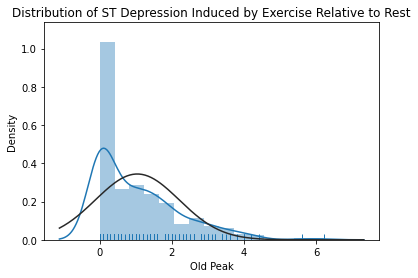

In [26]:
sns.distplot(data.oldpeak, rug=True, bins=15, fit=norm);
plt.title('Distribution of ST Depression Induced by Exercise Relative to Rest');
plt.xlabel('Old Peak');

## How does the classes in the categorical features vary in numbers according to the target feature?

In [27]:
# Make a copy of the original data as a precautionary measure to not modify the source data frame 
data_copy = data.copy()

In [28]:
# Encode categorical columns with categories for data visualisation understanding 
data_copy = data_copy.replace({'sex': {0 : 'Female', 1: 'Male'},
                              'cp': {0 : 'Typical angina', 1: 'Atypical angina',
                                     2: 'Non-anginal pain', 3: 'Asymptomatic'},
                              'fbs': {0 : 'No', 1: 'Yes'},
                              'restecg': {0 : 'Normal', 1: 'Abnormal', 2: 'Ventricular hypertrophy'},
                              'exang': {0 : 'No', 1: 'Yes'},
                              'slope': {0 : 'Upsloping', 1: 'Flat', 2: 'Downsloping'},
                              'ca': {0 : 'Mild', 1: 'Moderate', 2: 'Mild Severe',
                                     3: 'Moderate Severe', 4: 'Extreme Severe'},
                              'thal': {0 : 'Normal', 1: 'Fixed defect', 2: 'Reversible defect',
                                       3: 'Extra Defect'},
                              'target': {0 : 'No', 1: 'Yes'}})

In [29]:
data_copy.sample(10)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
16,51,Female,Non-anginal pain,140,308,No,Normal,142,No,1.5,Downsloping,Moderate,Reversible defect,Yes
733,44,Female,Non-anginal pain,108,141,No,Abnormal,175,No,0.6,Flat,Mild,Reversible defect,Yes
13,51,Male,Typical angina,140,298,No,Abnormal,122,Yes,4.2,Flat,Moderate Severe,Extra Defect,No
449,52,Male,Typical angina,112,230,No,Abnormal,160,No,0.0,Downsloping,Moderate,Reversible defect,No
45,42,Male,Typical angina,140,226,No,Abnormal,178,No,0.0,Downsloping,Mild,Reversible defect,Yes
319,53,Female,Non-anginal pain,128,216,No,Normal,115,No,0.0,Downsloping,Mild,Normal,Yes
149,39,Male,Non-anginal pain,140,321,No,Normal,182,No,0.0,Downsloping,Mild,Reversible defect,Yes
376,59,Male,Atypical angina,140,221,No,Abnormal,164,Yes,0.0,Downsloping,Mild,Reversible defect,Yes
142,61,Male,Asymptomatic,134,234,No,Abnormal,145,No,2.6,Flat,Mild Severe,Reversible defect,No
24,42,Female,Non-anginal pain,120,209,No,Abnormal,173,No,0.0,Flat,Mild,Reversible defect,Yes


* The charts below(bar plots) provides a count comparsion within each class present in the categorical feature being dsiplayed according to the target feature (heart disease). This informs on the number of patients positive of heart disease in each class

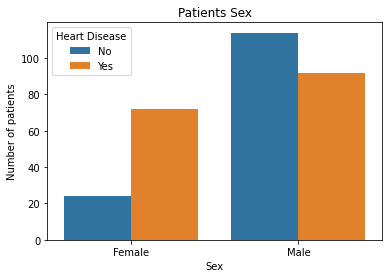

In [30]:
sex_cls = data_copy.groupby(['sex', 'target']).sex.count().reset_index(name='count')
sns.barplot(x="sex", y="count", data=sex_cls, hue = "target");
plt.title('Patients Sex');
plt.xlabel('Sex');
plt.ylabel('Number of patients');
plt.legend(title = "Heart Disease");

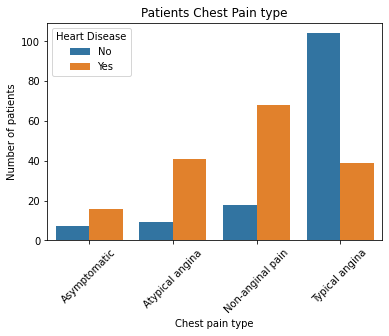

In [31]:
cp_cls = data_copy.groupby(['cp', 'target']).cp.count().reset_index(name='count')
sns.barplot(x="cp", y="count", data=cp_cls, hue = "target");
plt.title('Patients Chest Pain type');
plt.xlabel('Chest pain type');
plt.ylabel('Number of patients');
plt.xticks(rotation=45);
plt.legend(title = "Heart Disease");

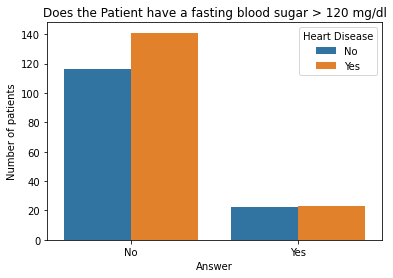

In [32]:
fbs_cls = data_copy.groupby(['fbs', 'target']).fbs.count().reset_index(name='count')
sns.barplot(x="fbs", y="count", data=fbs_cls, hue = "target");
plt.title('Does the Patient have a fasting blood sugar > 120 mg/dl');
plt.xlabel('Answer');
plt.ylabel('Number of patients');
plt.legend(title = "Heart Disease");

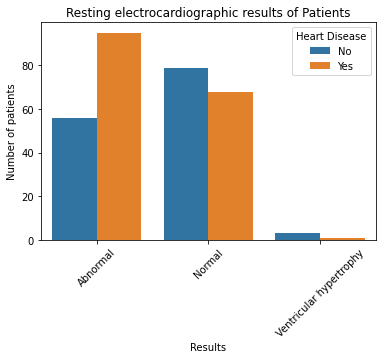

In [33]:
restecg_cls = data_copy.groupby(['restecg', 'target']).restecg.count().reset_index(name='count')
sns.barplot(x="restecg", y="count", data=restecg_cls, hue = "target");
plt.title('Resting electrocardiographic results of Patients');
plt.xlabel('Results');
plt.ylabel('Number of patients');
plt.xticks(rotation=45);
plt.legend(title = "Heart Disease");

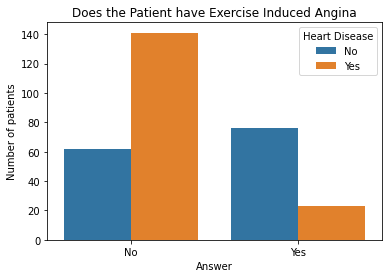

In [34]:
exang_cls = data_copy.groupby(['exang', 'target']).exang.count().reset_index(name='count')
sns.barplot(x="exang", y="count", data=exang_cls, hue = "target");
plt.title('Does the Patient have Exercise Induced Angina');
plt.xlabel('Answer');
plt.ylabel('Number of patients');
plt.legend(title = "Heart Disease");

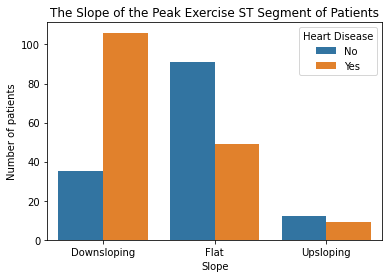

In [35]:
slope_cls = data_copy.groupby(['slope', 'target']).slope.count().reset_index(name='count')
sns.barplot(x="slope", y="count", data=slope_cls, hue = "target");
plt.title('The Slope of the Peak Exercise ST Segment of Patients');
plt.xlabel('Slope');
plt.ylabel('Number of patients');
plt.legend(title = "Heart Disease");

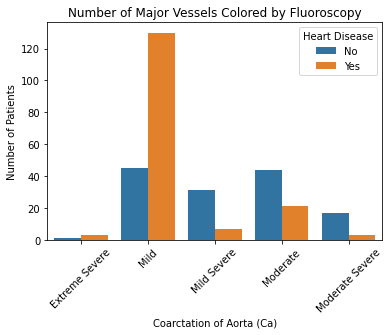

In [36]:
ca_cls = data_copy.groupby(['ca', 'target']).ca.count().reset_index(name='count')
sns.barplot(x="ca", y="count", data=ca_cls, hue = "target");
plt.title('Number of Major Vessels Colored by Fluoroscopy');
plt.xlabel('Coarctation of Aorta (Ca)');
plt.ylabel('Number of Patients');
plt.xticks(rotation=45);
plt.legend(title = "Heart Disease");

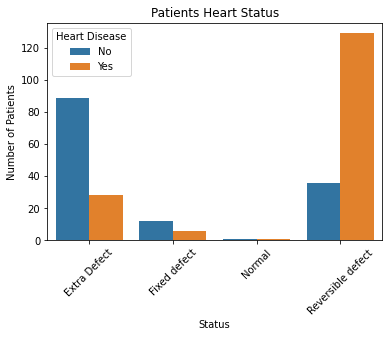

In [37]:
thal_cls = data_copy.groupby(['thal', 'target']).thal.count().reset_index(name='count')
sns.barplot(x="thal", y="count", data=thal_cls, hue = "target");
plt.title('Patients Heart Status');
plt.xlabel('Status');
plt.ylabel('Number of Patients');
plt.xticks(rotation=45);
plt.legend(title = "Heart Disease");

## How are the numerical features distributed according to the target feature

- The charts below (Violin plots) represent the distribution of the numerical features according to the target feature (Heart Disease). This informs on concentration of data points for the numerical feature being observed according to the target feature (Heart Disease). Similar to the distributions plots (Histogram and KDE), the peak of the violin plot curve/shape is where most of the data points for the numerical feature are occurring. This will advise on the most probable age, trestbps, chol, thalach and oldpeak of patients that have Heart Disease and patients that do not have heart disease. The mean and median shown on the violin plots is to observe if the distribution of the numerical features being observed according to the target feature  are positively, negatively or symmetrically skewed. <br><br>

- `If the mean is greater than the median, the distribution is positively skewed.` This means most of the data points are clustered or occur on the left tail (left side) of the distribution *(violin plot figure below: Bottom side)*
- `If the mean is less than the median, the distribution is negatively skewed.` This means most of the data points are clustered or occur on the right tail (right side) of the distribution *(violin plot figure below: Top side)*
- `If the mean and median are the same or close, then the distribution is fairly symmetric.` This means the data points are fairly distributed *(on the violin plot figure below: Both sides)* 


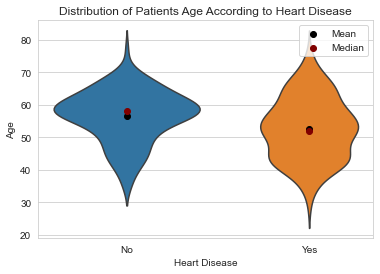

In [38]:
sns.set_style('whitegrid') # grid to easily make sense of numbers in plots
cust_col = ["#1f77b4", "#ff7f0e"] # own custom color scheme 
sns.set_palette(cust_col) # set color scheme

age_mean = data_copy.groupby('target')['age'].mean() # calculate group mean
age_median = data_copy.groupby('target')['age'].median() # calculate group median 
age_order = data_copy.groupby('target')['age'].mean().iloc[::1].index # calculate mean for grouping according to mean
sns.violinplot(x='target', y='age', data=data_copy, inner=None, order=age_order);
plt.title('Distribution of Patients Age According to Heart Disease');
plt.xlabel('Heart Disease');
plt.ylabel('Age');
plt.scatter(x=range(len(age_mean)),y=age_mean,c="k", label = "Mean");
plt.scatter(x=range(len(age_median)),y=age_median, c="maroon", label = "Median");
plt.legend();

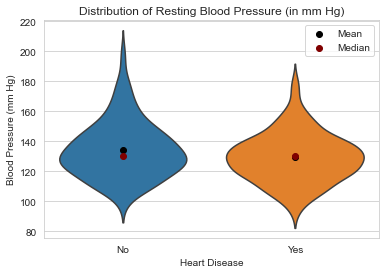

In [39]:
trestbps_mean = data_copy.groupby('target')['trestbps'].mean() 
trestbps_median = data_copy.groupby('target')['trestbps'].median() 
trestbps_order = data_copy.groupby('target')['trestbps'].mean().iloc[::1].index 
sns.violinplot(x='target', y='trestbps', data=data_copy, inner=None, order=trestbps_order);
plt.title('Distribution of Resting Blood Pressure (in mm Hg)');
plt.xlabel('Heart Disease');
plt.ylabel('Blood Pressure (mm Hg)');
plt.scatter(x=range(len(trestbps_mean)),y=trestbps_mean,c="k", label = "Mean");
plt.scatter(x=range(len(trestbps_median)),y=trestbps_median, c="maroon", label = "Median");
plt.legend();

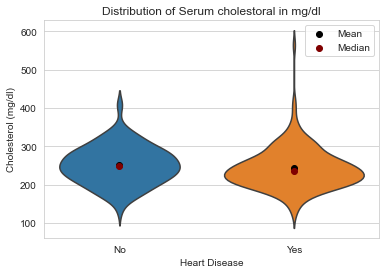

In [40]:
chol_mean = data_copy.groupby('target')['chol'].mean() 
chol_median = data_copy.groupby('target')['chol'].median() 
chol_order = data_copy.groupby('target')['chol'].mean().iloc[::1].index 
sns.violinplot(x='target', y='chol', data=data_copy, inner=None, order=chol_order);
plt.title('Distribution of Serum cholestoral in mg/dl');
plt.xlabel('Heart Disease');
plt.ylabel('Cholesterol (mg/dl)');
plt.scatter(x=range(len(chol_mean)),y=chol_mean,c="k", label = "Mean");
plt.scatter(x=range(len(chol_median)),y=chol_median, c="maroon", label = "Median");
plt.legend();

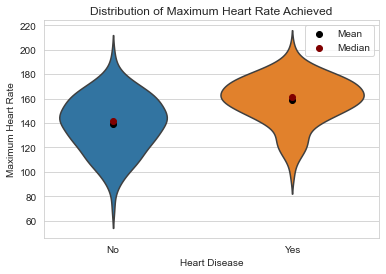

In [41]:
thalach_mean = data_copy.groupby('target')['thalach'].mean() 
thalach_median = data_copy.groupby('target')['thalach'].median() 
thalach_order = data_copy.groupby('target')['thalach'].mean().iloc[::1].index 
sns.violinplot(x='target', y='thalach', data=data_copy, inner=None, order=thalach_order);
plt.title('Distribution of Maximum Heart Rate Achieved');
plt.xlabel('Heart Disease');
plt.ylabel('Maximum Heart Rate');
plt.scatter(x=range(len(thalach_mean)),y=thalach_mean,c="k", label = "Mean");
plt.scatter(x=range(len(thalach_median)),y=thalach_median, c="maroon", label = "Median");
plt.legend();

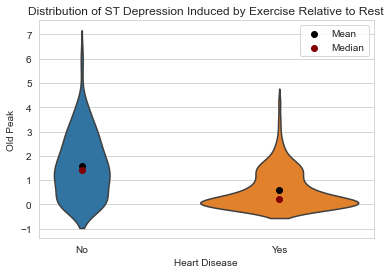

In [42]:
oldpeak_mean = data_copy.groupby('target')['oldpeak'].mean() 
oldpeak_median = data_copy.groupby('target')['oldpeak'].median() 
oldpeak_order = data_copy.groupby('target')['oldpeak'].mean().iloc[::1].index 
sns.violinplot(x='target', y='oldpeak', data=data_copy, inner=None, order=oldpeak_order);
plt.title('Distribution of ST Depression Induced by Exercise Relative to Rest');
plt.xlabel('Heart Disease');
plt.ylabel('Old Peak');
plt.scatter(x=range(len(oldpeak_mean)),y=oldpeak_mean,c="k", label = "Mean");
plt.scatter(x=range(len(oldpeak_median)),y=oldpeak_median, c="maroon", label = "Median");
plt.legend();

## Class Representation 

The project problem is a classification problem in which a patient is classified as either healthy or sick (Having a heart disease or not). Many classification learning algorithms have low predictive accuracy for under-represented classes, this is due to the presence of class imbalance. Class imbalance occurs when one class is not well represented in the data set. Thus class representation in the target feature will be checked. <br><br>
The following question will be looked into `Are all the classes well represented in the target feature? (Does class imbalance exist?)`

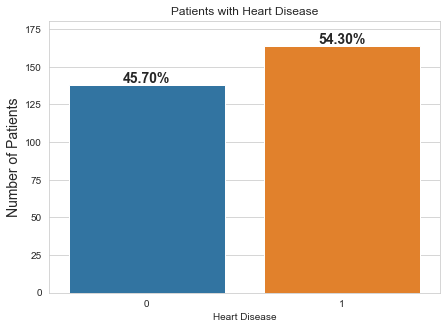

In [43]:
cust_col = ["#1f77b4","#ff7f0e"] # own custom color scheme 
sns.set_palette(cust_col) # set color scheme
total = len(data_copy)
plt.figure(figsize=(7,5))
g = sns.countplot(x='target', data=data)
g.set_ylabel('Count', fontsize=14)
for p in g.patches:
    height = p.get_height()
    g.text(p.get_x()+p.get_width()/2.,
            height + 1.5,
            '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=14, fontweight='bold')
plt.margins(y=0.1)
plt.title('Patients with Heart Disease');
plt.xlabel('Heart Disease');
plt.ylabel('Number of Patients');
plt.show()

From the figure above, it is evident that the classes are fairly well represented, so there is no need for techniques to handle class imbalance in the target variable. 

## Data Check
- This is check if data preparation is needed for model building
- For model building the source data set will be used. 

In [44]:
print('Number of rows: ', data.shape[0])
print('Number of columns: ', data.shape[1])

Number of rows:  302
Number of columns:  14


In [45]:
data.sample(5)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
429,47,1,2,108,243,0,1,152,0,0.0,2,0,2,0
228,52,1,1,128,205,1,1,184,0,0.0,2,0,2,1
181,64,1,3,110,211,0,0,144,1,1.8,1,0,2,1
67,42,1,0,136,315,0,1,125,1,1.8,1,0,1,0
271,44,1,1,120,263,0,1,173,0,0.0,2,0,3,1


In [46]:
data.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,302.00000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000
mean,54.42053,0.682119,0.963576,131.602649,246.500000,0.149007,0.526490,149.569536,0.327815,1.043046,1.397351,0.718543,2.314570,0.543046
std,9.04797,0.466426,1.032044,17.563394,51.753489,0.356686,0.526027,22.903527,0.470196,1.161452,0.616274,1.006748,0.613026,0.498970
min,29.00000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,48.00000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.250000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.50000,1.000000,1.000000,130.000000,240.500000,0.000000,1.000000,152.500000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.00000,1.000000,2.000000,140.000000,274.750000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.00000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


- From the column and row check, it is observed that the number of features and observations displayed after obtaining a statistical summary of the data matches the numbers output from row and column counts
- It is also observable that every column is numerically expressed, which is essential for machine learning models, as machines learn well with data expressed numerically. 

## Feature Selection
- The features used for training machine learning models have a huge influence on the performance. Irrelevant or partially relevant features can negatively impact model performance. 
- Some the of the questions mentioned in the `Questions to understand the heart disease data set` section is answered in the process of feature selection. <br>
`Feature Selection` is the process of automatically selecting features in the data set that contributes most to the prediction  of target feature or output of interest. 

**Three benefits of performing feature selection before modeling data** <br>
- Reduces Overfitting: Less redundant data means less opportunity to make decisions based on noise.
- Improves Accuracy: Less misleading data means modeling accuracy improves.
- Reduces Training Time: Less data means that algorithms train faster.

Question answered in the feature selection sections `Are the predictor features related to the response feature?` and `Which features are most predictive for heart disease diagnosis?` 

### Correlation Analysis
- Correlation analysis will be used as a statistical method to evaluate the strength of relationships between all the features and for the target feature. This will help in establishing possible connections between features.

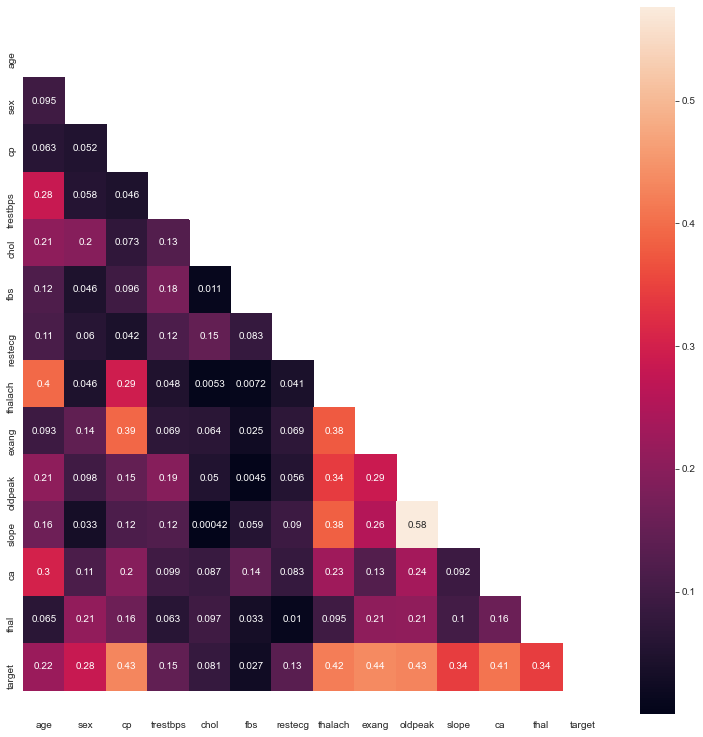

In [47]:
plt.figure(figsize=(13, 13))
corr = data.corr() 
mask = np.tri(*corr.shape).T 
sns.heatmap(corr.abs(), mask=mask, annot=True)
b, t = plt.ylim() 
b += 0.5 
t -= 0.5 
plt.ylim(b, t) 
plt.show()

- From the last row output in the figure above, we can observe the relationship the predictor features have with the target feature. 
- It is observed that all the relationships are positive, as all the correlation output values are above 0
- From the output, the variables that have correlation values above 0.30 will be considered to have an a weak uphill (positive) relationship with the target variable. In the context of the output, they are considered to have the strongest connections with the target feature. 
- The following features - *`cp, thalach, exang, oldpeak, slope, ca, thal`* all have correlation values above 0.30 establishing a proper connection to the target feature. 

In [48]:
cr_data = data.copy()

In [49]:
cr_data.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0


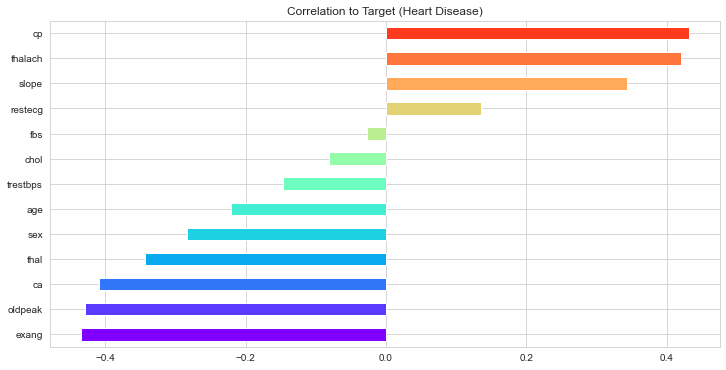


 cp          0.432080
thalach     0.419955
slope       0.343940
restecg     0.134874
fbs        -0.026826
chol       -0.081437
trestbps   -0.146269
age        -0.221476
sex        -0.283609
thal       -0.343101
ca         -0.408992
oldpeak    -0.429146
exang      -0.435601
dtype: float64


In [50]:
n_fts = len(cr_data.columns)
colors = cm.rainbow(np.linspace(0, 1, n_fts))

cr_data.drop('target',axis=1).corrwith(cr_data.target).sort_values(ascending=True).plot(kind='barh', 
                                                                                     color=colors, figsize=(12, 6))
plt.title('Correlation to Target (Heart Disease)')
plt.show()

print('\n',cr_data.drop('target',axis=1).corrwith(cr_data.target).sort_values(ascending=False))

In [51]:
cr_data['fbs'] = -cr_data['fbs']
cr_data['chol'] = -cr_data['chol']
cr_data['trestbps'] = -cr_data['trestbps']
cr_data['age'] = -cr_data['age']
cr_data['sex'] = -cr_data['sex']
cr_data['thal'] = -cr_data['thal']
cr_data['ca'] = -cr_data['ca']
cr_data['oldpeak'] = -cr_data['oldpeak']
cr_data['exang'] = -cr_data['exang']

corr = cr_data.corr() 

cor_target = corr["target"]

## In this senerio we will consider relevant predictor features to the target 
## as features that have a correlation value greater than 0.20 
relevant_features = cor_target[cor_target > 0.20]
relevant_features.sort_values(ascending=False)

target     1.000000
exang      0.435601
cp         0.432080
oldpeak    0.429146
thalach    0.419955
ca         0.408992
slope      0.343940
thal       0.343101
sex        0.283609
age        0.221476
Name: target, dtype: float64

### Recursive Feature Elimination 
- The Recursive Feature Elimination (or RFE) works by recursively removing attributes and building a model on those attributes that remain
- It uses the model accuracy to identify which predictor features contribute the most to predicting the target feature.
- RFE is used with the logistic regression algorithm to select the top 9 features. 

In [52]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

In [53]:
data.columns

Index(['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target'],
      dtype='object')

In [54]:
array= data.values

In [55]:
X_feat= array[:,0:13]
Y_feat = array[:,13]

In [56]:
#feature extraction
model = LogisticRegression(solver='lbfgs')
rfe = RFE(model,9)
fit = rfe.fit(X_feat, Y_feat)
print("No. features: %d" % fit.n_features_)
print("Selected features: %s" % fit.support_)
print("Feature ranking: %s" % fit.ranking_)

No. features: 9
Selected features: [False  True  True False False  True  True False  True  True  True  True
  True]
Feature ranking: [4 1 1 3 5 1 1 2 1 1 1 1 1]


C:\Users\Mfund\anaconda3\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass n_features_to_select=9 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
C:\Users\Mfund\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Mfund\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of i

**The output above**
- Num Features: 9
- Selected Features: [False  True  True False False False  True  True  True  True  True  True True]
- Feature Ranking: [4 1 1 2 5 3 1 1 1 1 1 1 1] 
- The Trues and 1s are the most important features selected, it corresponds with the output of data.columns<br>

Reason for selecting 9 features is due to the 9 correlated features selected in correlation analysis with a correlation boundary value of greater than 0.20. <br>
From the output above RFE chose the top 9 features as *`sex, cp, restecg, thalach, exang, oldpeak, slope, ca, and thal`*<br>
From the Correlation >0.20 output, the correlated features were *`exang, cp, oldpeak, thalach, ca, slope, thal, sex, age`*<br>
All the features match using both methods except for *`restecg and age`*. 

### Feature Importance
- Extra Trees will be used to estimate the importance of features.
- ExtraTreesClassifier will be constructed for this task

In [57]:
from sklearn.ensemble import ExtraTreesClassifier
import random
random.seed(0)

In [58]:
#copy data to avoid modificatiion of orginaL DATA
fi_data = data.copy()

In [59]:
fi_data.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0


In [60]:
X = fi_data.loc[:, fi_data.columns != 'target']
y = fi_data.target 

In [61]:
# feature extraction
model = ExtraTreesClassifier(n_estimators=15)
model.fit(X, y)

ExtraTreesClassifier(n_estimators=15)

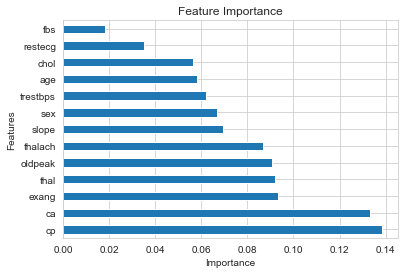

In [62]:
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(20).plot(kind='barh');
plt.title('Feature Importance');
plt.xlabel('Importance');
plt.ylabel('Features');

**Output Above**
- Using ExtraTreesClassifier the Top 9 most important features are *`cp, ca, exang, thal, oldpeak, thalach, chol, trestbps, slope`* and the least are *`age, sex, restecg, fbs`*


### Model Features
The common features appearing in all 3 feature selection techniques will be selected for modeling.

**Correlation Analysis**
- Top Features - `exang, cp, oldpeak, thalach, ca, slope, thal, sex, age`<br>

**Recursive Feature Elimination**
- Top Features - `sex, cp, restecg, thalach, exang, oldpeak, slope, ca, and thal`<br>

**ExtraTress Feature Importance**
- Top Features - `cp, ca, exang, thal, oldpeak, thalach, chol, trestbps, slope` <br>

**Common Features in all 3 Techniques**
- Features in all 3 - `exang, cp, oldpeak, thalach, ca, slope, thal`<br>
- Features in 2/3 - `sex`
- Sex appeared in Correlation Analysis and Recursive Feature Elimination
- Age appeared in Correlation Analysis and ExtraTress Feature Importance

# Model Building Results and Discussions


## Are there any outliers?
- Before modeling, an outlier check will done using a scatter plot of the Features selected in feature selection. 
- `Outlier:` An outlier is a data point that differs significantly from other observations. An outlier may be due to variability in the measurement or it may indicate experimental error
- Modeling Features: `exang, cp, oldpeak, thalach, ca, slope, thal`

In [63]:
# Re-reading the data, the data is already proper for modeling procedures, as it was not modified above
model_features = ['cp', 'thalach', 'exang', 'oldpeak', 'slope', 'thal', 'target']
m_data = data.copy()
m_data = m_data[model_features]

In [64]:
m_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 302 entries, 0 to 878
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   cp       302 non-null    int64  
 1   thalach  302 non-null    int64  
 2   exang    302 non-null    int64  
 3   oldpeak  302 non-null    float64
 4   slope    302 non-null    int64  
 5   thal     302 non-null    int64  
 6   target   302 non-null    int64  
dtypes: float64(1), int64(6)
memory usage: 27.0 KB


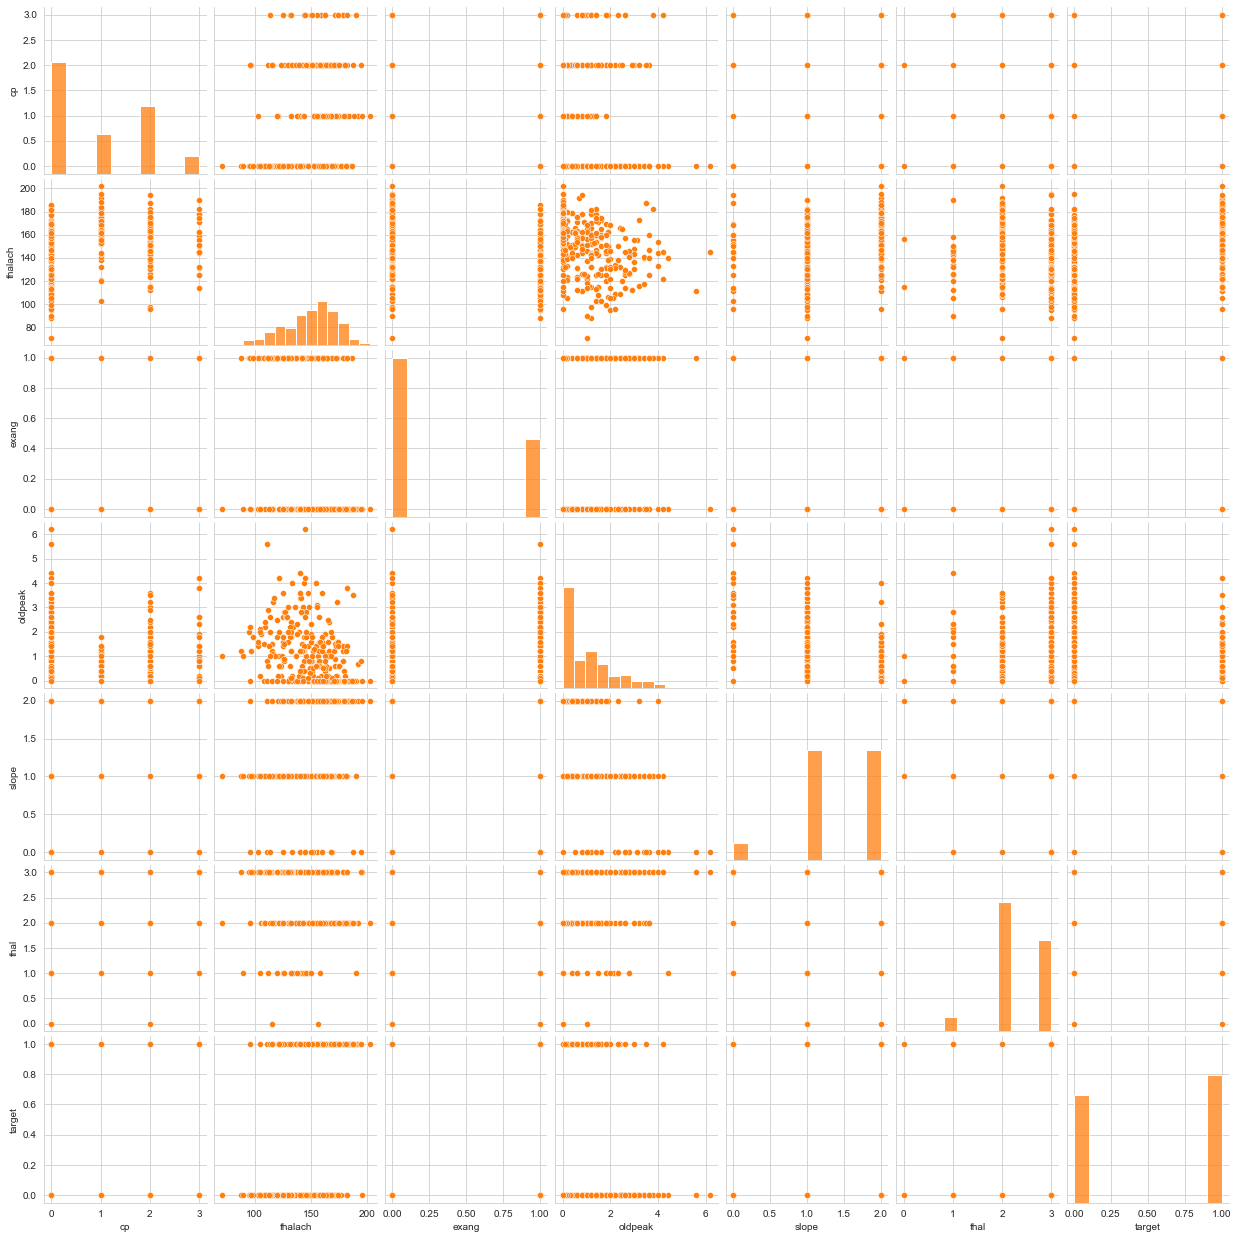

In [65]:
# Scatter plot of the model features, for outlier check
cust_col = ["#ff7f0e", "#1f77b4"] # own custom color scheme 
sns.set_palette(cust_col) # set color scheme
sns.pairplot(m_data);

- As observed above, there are nearly no data points that significantly differs from the observations, thus no outlier handling techniques will be used. 